In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

import math
from sklearn.decomposition import PCA

In [63]:
class Dart: 
    def __init__(self, centroids, dartNumber, isStrayGroup, posX, posY):
        self.centroids = centroids
        self.dartNumber = dartNumber
        self.isStrayGroup = isStrayGroup
        self.posX = posX
        self.posY = posY

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def includedInCone(point, vertex, threshhold_quadratic_function):
    if point[1] >= vertex[1]:
        y_distance = point[1] - vertex[1]
        
        x1 = vertex[0] - threshhold_quadratic_function * math.sqrt(y_distance)  
        x2 = vertex[0] + threshhold_quadratic_function * math.sqrt(y_distance)  
        
        return x1 < point[0] < x2
    return False

def brighten_image(image, factor):
    if factor < -1 or factor > 255:
        raise ValueError("Factor must be between 0 and 255.")
    brightened_image = image.astype(np.int16) + factor
    return np.clip(brightened_image, 0, 255).astype(np.uint8)

def enhance_contrast(image, factor):
    if factor < 0:
        raise ValueError("Factor must be positive.")
    contrast_image = image.astype(np.int16)
    contrast_image = 128 + factor * (contrast_image - 128)
    return np.clip(contrast_image, 0, 255).astype(np.uint8)

def prepareMask(emptyFrame, dartFrame):
    brightness_factor = 10
    empty_dartboard_bright = brighten_image(emptyFrame, brightness_factor)
    dartboard_with_darts_bright = brighten_image(dartFrame, 0)

    contrast_factor = 1.2
    empty_dartboard_contrast = enhance_contrast(empty_dartboard_bright, contrast_factor)
    dartboard_with_darts_contrast = enhance_contrast(dartboard_with_darts_bright, 1.3)
    
    empty_gray = cv2.cvtColor(empty_dartboard_contrast, cv2.COLOR_BGR2GRAY)
    darts_gray = cv2.cvtColor(dartboard_with_darts_contrast, cv2.COLOR_BGR2GRAY)
    
    difference = cv2.absdiff(empty_gray, darts_gray)
    difference = enhance_contrast(difference, 1.5) 
    
    _, mask = cv2.threshold(difference, 40, 255, cv2.THRESH_BINARY)
    cv2.imwrite("premask.jpg",difference)
    
    kernel = np.ones((3, 3), np.uint8) 
    mask_eroded = cv2.erode(mask, kernel, iterations=1)
    
    kernel = np.ones((2, 2), np.uint8) 
    mask_dilated = cv2.dilate(mask_eroded, kernel, iterations=1)

    #Ideas for the future:
    #add dilatation and then
    #blob detection from opencv

    #dilate and erode again for closing the holes inside the darts themselfes

    #take difference from hsv images, not gray scaled
    return mask_dilated

def findPointsInMask(mask, min_area_threshold):
    #Find Centerpoints in Contours of Mask
    contours_in_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []

    for contour_mask in contours_in_mask:
        area = cv2.contourArea(contour_mask)
        
        if area > min_area_threshold:
            #Append Highgest Point
            topmost_point = min(contour_mask, key=lambda point: point[0][1])  
            cx, cy = int(topmost_point[0][0]), int(topmost_point[0][1])
            centroids.append((cx, cy))
            #Append Centerpoints
            M = cv2.moments(contour_mask)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                centroids.append((cx, cy))
    return centroids



def findDartPositions(groups, currentRunDarts):
    used_positions = {(dart.posX, dart.posY) for dart in currentRunDarts}
    for group in groups:
        if group.isStrayGroup or (group.posX, group.posY) in used_positions:
            continue

        sorted_group = sorted(group.centroids, key=lambda y: y[1])
        group.posX = sorted_group[0][0]
        group.posY = sorted_group[0][1]
    return groups

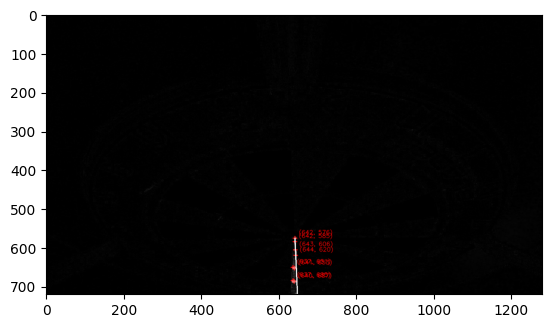

[<__main__.Dart object at 0x164d26a80>, <__main__.Dart object at 0x164c9fce0>]


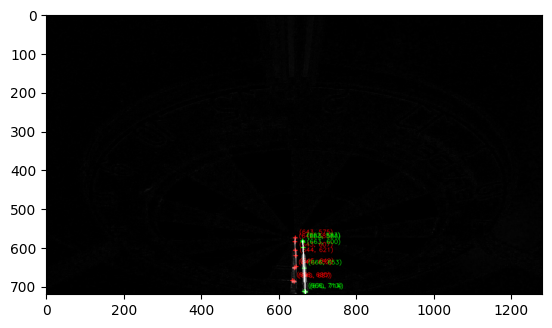

[[643, 575, 1], [662, 583, 2]]
[<__main__.Dart object at 0x164c4bbc0>, <__main__.Dart object at 0x164ac7560>, <__main__.Dart object at 0x1642295b0>]


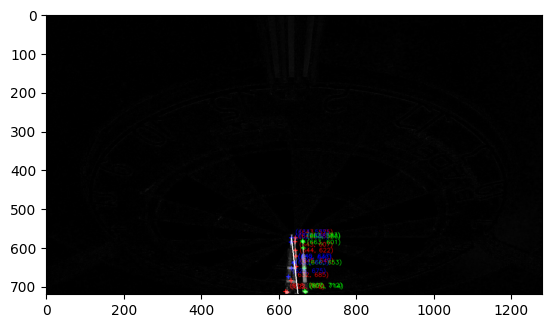

[[643, 575, 1], [662, 583, 2], [633, 575, 3]]


In [143]:
def findClosestPoint(current_point, centroids):
    nearest_point = None
    min_distance = float('inf')
    for centroid in centroids:
        distance = euclidean_distance(centroid, current_point)
        
        if distance < min_distance:
            min_distance = distance
            nearest_point = centroid
    return nearest_point

def findClosestPointBasedOnLine(slope, intercept, points, init_y, used_points, tolerance=2, evaluateUsedDarts=False):
    nearest_point = None
    min_distance_to_line = float('inf')
    
    for point in points:
        x0, y0 = point

        # Überprüfen, ob der Punkt bereits in `used_points` ist, unter Berücksichtigung der Toleranz
        if (any(abs(x0 - ux) <= tolerance and abs(y0 - uy) <= tolerance for ux, uy in used_points)) and not evaluateUsedDarts:
            continue  # Überspringe diesen Punkt, wenn er zu nah an einem benutzten Punkt liegt

        # Berechne den y-Wert auf der Linie, um den Abstand zu bestimmen
        y_position_on_dart = abs(y0 - init_y)

        # Setze die maximalen Abstandsschwellenwerte basierend auf dem y-Wert
        if y_position_on_dart < 200:
            max_distance_threshhold = 25
        elif y_position_on_dart < 300:
            max_distance_threshhold = 30
        elif y_position_on_dart < 400:
            max_distance_threshhold = 35
        else:
            max_distance_threshhold = 85

        # Berechne den Abstand des Punktes zur Linie
        distance_to_line = abs(slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)

        # Vergleiche den Abstand mit dem minimalen Abstand und Schwellenwert
        if distance_to_line < min_distance_to_line and distance_to_line < max_distance_threshhold:
            min_distance_to_line = distance_to_line
            nearest_point = point

    return nearest_point

def calculateLine(points):
    x = np.array([point[0] for point in points])
    y = np.array([point[1] for point in points])

    #PCA Hauptkomponenten Analyse
    pca = PCA(n_components=1)
    pca.fit(points)

    slope = pca.components_[0][1] / pca.components_[0][0]
    intercept = np.mean(y) - slope * np.mean(x)

    return slope, intercept

def drawLine(slope, line_mask, start_point):
    line_length = 600

    x_offset = line_length / np.sqrt(1 + slope**2)
    y_offset = slope * x_offset

    end_point = (int(start_point[0] + (x_offset if slope >= 0 else -x_offset)),
                int(start_point[1] + (y_offset if slope >= 0 else -y_offset)))
    
    cv2.line(line_mask, start_point, end_point, (255, 255, 255), 2)


def groupDots(centroids, point_mask, line_mask, adapting_rate, currentRunDarts, fluctationThreshhold):
    groups = []
    used_points = set() 

    if len(currentRunDarts) > 0:
        groups, centroids, used_points = analyzeDartCorrespondences(centroids, currentRunDarts, fluctationThreshhold)
    
    current_point = getTopMostPoint(centroids)
    processGrouping(current_point, centroids, point_mask, line_mask, adapting_rate, used_points, fluctationThreshhold, groups)

    if len(centroids) > 0:
        allGrouped, groups = tryAfterGrouping(centroids, groups)
        if not allGrouped:
            groups.append(Dart(centroids, 0, isStrayGroup=True, posX=0, posY=0))

    return groups, point_mask, line_mask

def analyzeDartCorrespondences(centroids, currentRunDarts, fluctationThreshhold):
    groups = []
    remaining_centroids = centroids.copy()
    used_points = set() 

    for dart in currentRunDarts:
        if dart.isStrayGroup:
            continue 

        highest_point = (dart.posX, dart.posY) 
        corresponding_points = [
            point for point in remaining_centroids
            if any(
                abs(point[0] - centroid[0]) <= fluctationThreshhold and
                abs(point[1] - centroid[1]) <= fluctationThreshhold
                for centroid in dart.centroids
            )
        ]

        if not corresponding_points:
            continue

        slope, intercept = calculateLine(corresponding_points)

        used_points.update(corresponding_points)
        for point in corresponding_points:
            remaining_centroids.remove(point)

        dart_points = corresponding_points.copy()

        # while (nearest_point := findClosestPointBasedOnLine(slope, intercept, remaining_centroids, highest_point[1], used_points, fluctationThreshhold)) is not None:
        #     used_points.update([nearest_point])
        #     dart_points.append(nearest_point)
        #     remaining_centroids.remove(nearest_point)

        groups.append(Dart(dart_points, len(groups) + 1, isStrayGroup=False, posX=0, posY=0))

    return groups, remaining_centroids, used_points


def processGrouping(current_point, centroids, point_mask, line_mask, adapting_rate, used_points, fluctationThreshhold, groups, evaluateUsedDarts=False):
    """Führt die gesamte Gruppierung für einen Startpunkt aus"""
    centroids.remove(current_point)
    nearest_points = [current_point]
    tmp_point = current_point

    for _ in range(min(len(centroids), adapting_rate)):
        nearest_point = findNextPoint(tmp_point, centroids, used_points, fluctationThreshhold)
        if nearest_point:
            tmp_point = nearest_point
            nearest_points.append(tmp_point)
            centroids.remove(nearest_point)

    slope, intercept = calculateLine(nearest_points)
    drawLine(slope, line_mask, nearest_points[0])

    updateLineAndGroup(nearest_points, centroids, slope, intercept, line_mask, used_points, fluctationThreshhold, evaluateUsedDarts)

    drawGroupedPoints(nearest_points, point_mask, line_mask)

    groups.append(Dart(nearest_points, len(groups) + 1, isStrayGroup=False, posX=0, posY=0))

def tryAfterGrouping(centroids, groups):
    for dart in groups: 
        highest_point = max(dart.centroids, key=lambda p: p[1])
        slope, intercept = calculateLine(dart.centroids)

        while (nearest_point := findClosestPointBasedOnLine(slope, intercept, centroids, highest_point[1], [], 0)) is not None:
            dart.centroids.append(nearest_point)
            centroids.remove(nearest_point)

    return len(centroids)==0, groups

# def groupDots(centroids, point_mask, line_mask, adapting_rate, currentRunDarts, fluctationThreshhold):
#     groups = []
#     used_points = getUsedPointsFromDarts(currentRunDarts)  

#     while len(centroids) > 0 and len(groups) < 3:
#         # 1️⃣ Finde den obersten Punkt, der noch nicht in previous darts enthalten ist
#         current_point = getTopMostNewPoint(centroids, used_points, fluctationThreshhold)
#         if current_point is None:
#             for dart in currentRunDarts:
#                 if dart.isStrayGroup:
#                     continue
                
#                 # 3️⃣ Hole den höchsten Punkt des aktuellen Darts
#                 highest_point = max(dart.centroids, key=lambda p: p[1])
#                 centroids_near_highest = [
#                     point for point in centroids if (abs(point[0] - highest_point[0]) <= fluctationThreshhold and
#                                                       abs(point[1] - highest_point[1]) <= fluctationThreshhold)
#                 ]
                
#                 if len(centroids_near_highest) > 0:
#                     current_point = centroids_near_highest[0]
#                     centroids.remove(current_point)
#                     break

#             if current_point is None:
#                 break  # Falls kein Punkt mehr gefunden wurde, abbrechen  # Falls alle Punkte bereits markiert sind, brechen wir ab

#         centroids.remove(current_point)
#         nearest_points = [current_point]
#         tmp_point = current_point

#         # 2️⃣ Finde initiale "adapting_rate" viele Punkte
#         for _ in range(min(len(centroids), adapting_rate)):
#             nearest_point = findNextPoint(tmp_point, centroids, used_points, fluctationThreshhold)
#             if nearest_point:
#                 tmp_point = nearest_point
#                 nearest_points.append(tmp_point)
#                 centroids.remove(nearest_point)

#         # 3️⃣ Berechne die erste Linie und beginne mit der Gruppierung
#         slope, intercept = calculateLine(nearest_points)
#         drawLine(slope, line_mask, nearest_points[0])

#         # 4️⃣ Weitermachen, bis keine passenden Punkte mehr gefunden werden
#         updateLineAndGroup(nearest_points, centroids, slope, intercept, line_mask, used_points, fluctationThreshhold)

#         # 5️⃣ Zeichne Punkte & Update Masken
#         drawGroupedPoints(nearest_points, point_mask, line_mask)

#         # 6️⃣ Speichere die neue Gruppe als Dart-Objekt
#         groups.append(Dart(nearest_points, len(groups) + 1, isStrayGroup=False, posX=0, posY=0))

#     return groups, point_mask, line_mask


def getUsedPointsFromDarts(currentRunDarts):
    used_points = set()
    for dart in currentRunDarts:
        if(dart.isStrayGroup):
            continue
        used_points.update(dart.centroids)
    return used_points

def getTopMostPoint(centroids):
    """Gibt den höchsten Punkt aus der Liste der centroids zurück."""
    if not centroids:
        return None
    return min(centroids, key=lambda point: point[1])  # Sortiert nach y-Wert (Höhe)

def getTopMostNewPoint(centroids, used_points, threshhold):
    sorted_centroids = sorted(centroids, key=lambda y: y[1]) 
    for point in sorted_centroids:
        px, py = point  
        #Add Threshhold for pixel fluctation between runtimes
        if not any(abs(px - ux) <= threshhold and abs(py - uy) <= threshhold for ux, uy in used_points):
            return point
    return None


def findNextPoint(current_point, centroids, used_points, threshhold):
    """ Findet den nächsten Punkt, bevorzugt aus neuen Punkten. Falls nicht möglich, nimmt er alte. """
    #Add Threhshold for pixel fluctation between runtimes
    new_points = [p for p in centroids if not any(abs(p[0] - ux) <= threshhold and abs(p[1] - uy) <= threshhold for ux, uy in used_points)]
    if new_points:
        return findClosestPoint(current_point, new_points)
    return findClosestPoint(current_point, centroids)


def updateLineAndGroup(nearest_points, centroids, slope, intercept, line_mask, used_points, threshhold, evaluateUsedDarts=False):
    """ Gruppiert weitere Punkte basierend auf der Linie und passt sie ggf. an. """
    points_grouped = 0
    init_y = nearest_points[0][1]
    
    while True:
        nearest_point = findClosestPointBasedOnLine(slope, intercept, centroids, init_y, used_points, threshhold, evaluateUsedDarts)
        if not nearest_point:
            break  # Falls kein weiterer Punkt gefunden wird, stoppen

        centroids.remove(nearest_point)
        nearest_points.append(nearest_point)
        points_grouped += 1

        if points_grouped % 7 == 0:  # Alle 7 Punkte Linie aktualisieren
            slope, intercept = calculateLine(nearest_points)
            drawLine(slope, line_mask, nearest_points[0])


def drawGroupedPoints(nearest_points, point_mask, line_mask):
    """ Zeichnet die gruppierten Punkte und aktualisiert das point_mask. """
    color = (85, 195, 189)
    for point in nearest_points:
        cv2.circle(point_mask, point, 3, color, -1)
    point_mask = cv2.add(point_mask, line_mask)

def drawCrossWithCoordinates(groups, dartFrame, colors):
    mask3 = np.zeros_like(dartFrame)  # Leere Maske für das Overlay

    for index, group in enumerate(groups):
        color = colors[index % len(colors)]  # Farbwahl für das Kreuz (abwechselnd)
        for (cx, cy) in group.centroids:
            # Kreuz zeichnen
            cv2.line(mask3, (cx - 5, cy), (cx + 5, cy), color, 2)  # Horizontale Linie
            cv2.line(mask3, (cx, cy - 5), (cx, cy + 5), color, 2)  # Vertikale Linie
            
            # Koordinaten als Text hinzufügen
            coordinate_text = f"({cx}, {cy})"
            cv2.putText(mask3, coordinate_text, (cx + 10, cy - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    
    return mask3

currentRunDarts = []
#Print out the results of the functions
def main(dartFrame, emptyFrame, printOut, run):
    dartFrameRotated = cv2.rotate(dartFrame, cv2.ROTATE_180)
    emptyFrameRotated = cv2.rotate(emptyFrame, cv2.ROTATE_180)

    gray_dart = cv2.cvtColor(dartFrameRotated, cv2.COLOR_BGR2GRAY)
    gray_empty = cv2.cvtColor(emptyFrameRotated, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray_dart, gray_empty) 
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2BGR)

    #Build difference so only darts are left
    mask1 = prepareMask(emptyFrameRotated, dartFrameRotated)

    mask2 = np.zeros_like(mask1)
    #Find centroid points in mask, draw them into an empty mask, min area threshold removes ausreißer
    centroids = findPointsInMask(mask1, 5)
    for (cx, cy) in centroids:
        cv2.circle(mask2, (cx, cy), 3, (255, 0, 0), -1)

    point_mask = np.zeros_like(dartFrame)
    line_mask = np.zeros_like(dartFrame)

    groups, point_mask, line_mask = groupDots(centroids, point_mask, line_mask, 3, currentRunDarts, 5)

    #Neglect ausreißer and find positions for the dart groups 
    darts = findDartPositions(groups, currentRunDarts)
    currentRunDarts.clear()
    currentRunDarts.extend(darts)

    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (0, 255, 255)
    ]

    mask3 = drawCrossWithCoordinates(groups, dartFrame, colors)

    mask3 = cv2.add(line_mask, mask3)

    result_image = cv2.add(mask3, difference)
    if(printOut):
        print(darts)
        cv2.imwrite('difference_'+run+'.jpg', difference)
        cv2.imwrite('mask1_'+run+'.jpg', mask1)
        cv2.imwrite('mask2_'+run+'.jpg', mask2)
        cv2.imwrite('mask3_'+run+'.jpg', mask3)
        cv2.imwrite('result_'+run+'.jpg', result_image)
        cv2.imwrite('point_mask_'+run+'.jpg', point_mask)
        plt.imshow(result_image)
        plt.show()

    return [[dart.posX, dart.posY, dart.dartNumber] for dart in darts[0:3]]

dartFrame_og = cv2.imread('darts.jpg')
emptyFrame_og = cv2.imread('empty.jpg')

#main(dartFrame_og, emptyFrame_og, True) #Funktioniert

dartFrame_top = cv2.imread('./images/dart_top.jpg')
emptyFrame_top = cv2.imread('./images/empty_top.jpg')

#main(dartFrame_top, emptyFrame_top, True) 

dartFrame_left = cv2.imread('./images/dart_left.jpg')
emptyFrame_left = cv2.imread('./images/empty_left.jpg')

#main(dartFrame_left, emptyFrame_left, True) 

dartFrame_right = cv2.imread('./images/dart_right.jpg')
emptyFrame_right = cv2.imread('./images/empty_right.jpg')

#main(dartFrame_right, emptyFrame_right, True) 

dartFrame_gemein_right = cv2.imread('./images/gemein_right.jpg')
dartFrame_gemein_left = cv2.imread('./images/gemein_left.jpg')
dartFrame_gemein_top = cv2.imread('./images/gemein_top.jpg')

#main(dartFrame_gemein_top, emptyFrame_top, True)
#main(dartFrame_gemein_right, emptyFrame_right, True)
#main(dartFrame_gemein_left, emptyFrame_left, True)

dartFrame_gemein2_right = cv2.imread('./images/2/darts_right.jpg')
emptyFrame_gemein2_right = cv2.imread('./images/2/empty_right.jpg')

#main(dartFrame_gemein2_right, emptyFrame_gemein2_right, True)

dartFrame_gemein2_left = cv2.imread('./images/2/darts_left.jpg')
emptyFrame_gemein2_left = cv2.imread('./images/2/empty_left.jpg')

#main(dartFrame_gemein2_left, emptyFrame_gemein2_left, True)

dartFrame_gemein2_right = cv2.imread('./images/2/darts_top.jpg')
emptyFrame_gemein2_right = cv2.imread('./images/2/empty_top.jpg')

#main(dartFrame_gemein2_right, emptyFrame_gemein2_right, True)

#New Cams
dartFrame_New = cv2.imread('./images_new/leftDarts.jpg')
emptyFrame_New = cv2.imread('./images_new/leftEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

dartFrame_New = cv2.imread('./images_new/rightDarts.jpg')
emptyFrame_New = cv2.imread('./images_new/rightEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

dartFrame_New = cv2.imread('./images_new/2/leftDarts1.jpg')
emptyFrame_New = cv2.imread('./images_new/2/leftEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

dartFrame_New = cv2.imread('./images_new/2/rightDarts1.jpg')
emptyFrame_New = cv2.imread('./images_new/2/rightEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

dartFrame_New = cv2.imread('./images_new/2/leftDarts2.jpg')
emptyFrame_New = cv2.imread('./images_new/2/leftEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

dartFrame_New = cv2.imread('./images_new/2/rightDarts2.jpg')
emptyFrame_New = cv2.imread('./images_new/2/rightEmpty.jpg')

#main(dartFrame_New, emptyFrame_New, True)

#Complete Run Down here
currentRunDarts.clear()
emptyFrame_New = cv2.imread('./images_new/intervalls/EmptyRight.jpg')
dartFrame_New = cv2.imread('./images_new/intervalls/SingleRight.jpg')
#main(dartFrame_New, emptyFrame_New, False, "1")

dartFrame_New = cv2.imread('./images_new/intervalls/DoubleRight.jpg')
#main(dartFrame_New, emptyFrame_New, False, "2")

dartFrame_New = cv2.imread('./images_new/intervalls/TripleRight.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "3"))

emptyFrame_New = cv2.imread('./images_new/intervalls/EmptyLeft.jpg')
dartFrame_New = cv2.imread('./images_new/intervalls/SingleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "1"))

dartFrame_New = cv2.imread('./images_new/intervalls/DoubleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "2"))

dartFrame_New = cv2.imread('./images_new/intervalls/TripleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "3"))

emptyFrame_New = cv2.imread('./images_new/intervalls/fies/EmptyLeft.jpg')
dartFrame_New = cv2.imread('./images_new/intervalls/fies/SingleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "1"))

dartFrame_New = cv2.imread('./images_new/intervalls/fies/DoubleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "2"))

dartFrame_New = cv2.imread('./images_new/intervalls/fies/TripleLeft.jpg')
#print(main(dartFrame_New, emptyFrame_New, True, "3"))

emptyFrame_New = cv2.imread('./images_new/intervalls/fies/EmptyRight.jpg')
dartFrame_New = cv2.imread('./images_new/intervalls/fies/SingleRight.jpg')
main(dartFrame_New, emptyFrame_New, True, "1")

dartFrame_New = cv2.imread('./images_new/intervalls/fies/DoubleRight.jpg')
print(main(dartFrame_New, emptyFrame_New, True, "2"))

dartFrame_New = cv2.imread('./images_new/intervalls/fies/TripleRight.jpg')
print(main(dartFrame_New, emptyFrame_New, True, "3"))

In [5]:
import unittest

class TestMainMethod(unittest.TestCase):
    def test_main_return_value(self):
        dartFrame_og = cv2.imread('darts.jpg')
        emptyFrame_og = cv2.imread('empty.jpg')

        self.assertEqual(main(dartFrame_og, emptyFrame_og, False), [(1296, 460), (615, 604), (1027, 702)])

        dartFrame_top = cv2.imread('./images/dart_top.jpg')
        emptyFrame_top = cv2.imread('./images/empty_top.jpg')

        self.assertEqual(main(dartFrame_top, emptyFrame_top, False), [(549, 507), (1233, 512), (984, 673)])

        dartFrame_left = cv2.imread('./images/dart_left.jpg')
        emptyFrame_left = cv2.imread('./images/empty_left.jpg')

        self.assertEqual(main(dartFrame_left, emptyFrame_left, False), [(1288, 757), (541, 767), (970, 904)])

        dartFrame_right = cv2.imread('./images/dart_right.jpg')
        emptyFrame_right = cv2.imread('./images/empty_right.jpg')

        self.assertEqual(main(dartFrame_right, emptyFrame_right, False), [(1295, 670), (609, 730), (1050, 838)])

        dartFrame_gemein_right = cv2.imread('./images/gemein_right.jpg')
        dartFrame_gemein_left = cv2.imread('./images/gemein_left.jpg')
        dartFrame_gemein_top = cv2.imread('./images/gemein_top.jpg')

        self.assertEqual(main(dartFrame_gemein_top, emptyFrame_top, False), [(865, 368), (967, 385), (923, 404)])
        self.assertEqual(main(dartFrame_gemein_left, emptyFrame_left, False), [(1292, 880), (1231, 884)])       
        self.assertEqual(main(dartFrame_gemein_right, emptyFrame_right, False), [(642, 808), (678, 812)])

unittest.main(argv=[''], verbosity=2, exit=False)

test_main_return_value (__main__.TestMainMethod.test_main_return_value) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.883s

OK


In [ ]:
#Zweiter Approach über Im Raum Geöffnete Parabeln (zu ineffizient, wenn es auch mit Geraden geht)

def draw_function(vertex, slope):
    #Diagonal Quadratic Formula
    # y * cos(θ) + k * cos(θ) - x * sin(θ) - h * sin(θ) = a * ((x * cos(θ) + h * cos(θ)) + (y * sing(θ) + k * sin(θ)))^2
    a = 2 #Streckungsfaktor
    θ = 1 #Winkeldrehung der Gleichung
    k = 0 #y-Achsen Verschiebung
    h = 0 #x-Achsen Verschiebung

    # k = vertex[1]  # y-Achsen Verschiebung (vertex y)
    # h = vertex[0]

    print(vertex)

    cos_theta = np.cos(θ)
    sin_theta = np.sin(θ)

    mask = np.zeros_like(dartFrame)

    width = len(dartFrame)
    height = len(dartFrame[0])

    print(width)
    print(height)

    mul = 1

    for x in range(50):
        # Berechne y aus der quadratischen Formel
        # Umstellen der Formel nach y:
        # y * cos(θ) + k * cos(θ) - x * sin(θ) - h * sin(θ) = a * ((x * cos(θ) + h * cos(θ)) + (y * sin(θ) + k * sin(θ)))^2
        # Um die Gleichung nach y umzustellen, benötigen wir:
        # y * cos(θ) = x * sin(θ) + h * sin(θ) + a * ((x * cos(θ) + h * cos(θ))^2)
        
        # Berechnung
        y_term = (x * sin_theta + h * sin_theta - k * cos_theta + 
                   a * ((x * cos_theta + h * cos_theta) ** 2))

        # Überprüfe, ob cos(θ) nicht null ist, um Division durch Null zu vermeiden
        if cos_theta != 0:
            y = y_term / cos_theta
        else:
            y = np.inf
        print(y)

        # Überprüfe, ob der y-Wert innerhalb der Maske liegt
        if 0 <= int(y) < height:
            x_trans = vertex[0] + x * mul
            y_trans = vertex[1] + int(y)
            cv2.circle(mask, (x_trans, y_trans), 5, (255, 255, 255), -1)
            mul *= -1
    
    cv2.imwrite('quadratic.jpg', mask)

    return mask